In [16]:
import pandas as pd
import numpy as np
import os
import gc
import time
import lightgbm as lgb
from lightgbm import plot_importance
import sys
sys.path.append('../brand_detector/py_model')
from utils import init_logging
import logging
import multiprocessing as mp # for speeding up some process
import pickle
import warnings
from datetime import datetime # for the newest version control

# configuration of shopee data: train/val/test = 35/15/50
# hold-out method. the reason we do not use out-of-fold is quite complicated to make sure each validating fold  is unseen brand for training brand. Also, at the same time to keep using the f1-score mesurement.
# So, for simplicity, just using hold-out method, that's also fine for our task. we also can trust our cv result. No need to do out-of-fold cross validation

In [17]:
#---------------------
# load features
#---------------------
feature_amazon_dir = '../brand_detector/features/beauty_amazon'
feature_shopee_dir = '../brand_detector/features/personal_care_and_beauty'

personal_care_and_beauty_shopee_df = pd.read_hdf(os.path.join(feature_shopee_dir, 'all_features.h5'))
beauty_amazon_df = pd.read_hdf(os.path.join(feature_amazon_dir, 'all_features.h5'))
# configuration of shopee data: train/val/test = 35/15/50 (0,1,2)
train = pd.concat([beauty_amazon_df, personal_care_and_beauty_shopee_df[personal_care_and_beauty_shopee_df.is_valid == 0]], axis = 0)
val = personal_care_and_beauty_shopee_df[personal_care_and_beauty_shopee_df.is_valid == 1]
test = personal_care_and_beauty_shopee_df[personal_care_and_beauty_shopee_df.is_valid == 2]
del personal_care_and_beauty_shopee_df, beauty_amazon_df
print ('train', train.shape)
print ('val', val.shape)
print ('test', test.shape)
#----------------------
# hold-out train/val split for base model
#----------------------
# val
x_val = val.drop(['item_name', 'tokens', 'label', 'is_valid'], axis = 1)
y_val = val.label
# test
x_test = test.drop(['item_name', 'tokens', 'label', 'is_valid'], axis = 1)
y_test = test.label
# train
x_train = train.drop(['item_name', 'tokens', 'label', 'is_valid'], axis = 1)
y_train = train.label
print ('x shape', x_train.shape, x_val.shape, x_test.shape)
print ('y shape', y_train.shape, y_val.shape, y_test.shape)

# for custom_f1
val_for_f1 = val[['item_name', 'tokens', 'label']].copy()
val_for_f1.rename(columns = {'label': 'y_true'}, inplace = True)


train (819268, 608)
val (8034, 608)
test (20778, 608)
x shape (819268, 604) (8034, 604) (20778, 604)
y shape (819268,) (8034,) (20778,)


# label distribution of train and val
### 1. It's quite imbalanced on training data set.
### 2. Our hold-out method make val set consistent with train set on label distribution

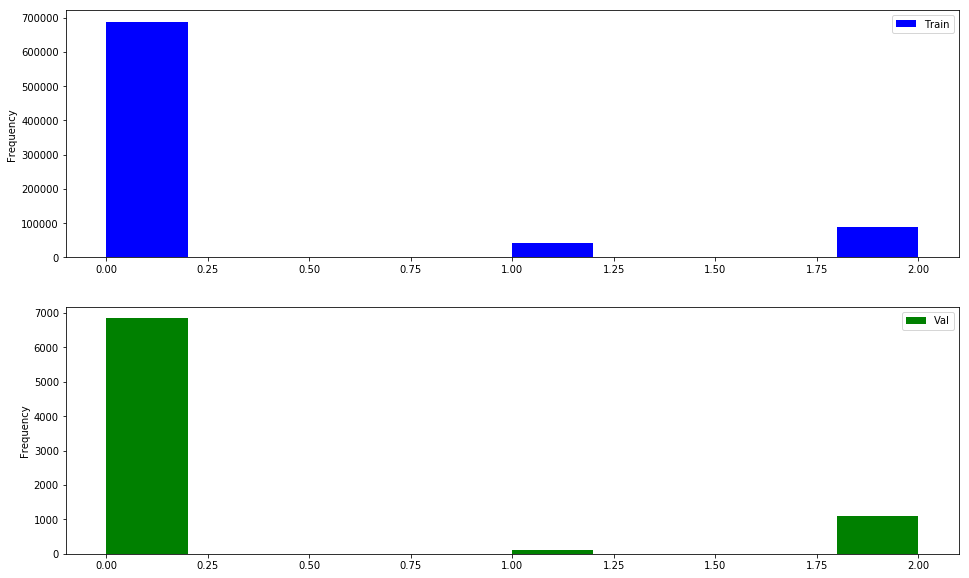

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

#---------------------------
# standard setting 
#---------------------------
fig, ax = plt.subplots(nrows=2, sharex=False, sharey=False)

y_train.plot(kind = 'hist', ax = ax[0], color = 'blue',legend = True, label = 'Train', density = False)
y_val.plot(kind = 'hist', ax = ax[1], color = 'green',legend = True, label = 'Val', density = False)

# check if brand of val and test is not duplicated

In [19]:
val_brand_name = val[val.label != 0].groupby('item_name').tokens \
.apply(lambda x: ' '.join(list(x))).to_frame('brand_name').reset_index()
test_brand_name = test[test.label != 0].groupby('item_name').tokens \
.apply(lambda x: ' '.join(list(x))).to_frame('brand_name').reset_index()
train_brand_name_w_amazon = train[train.label != 0].groupby('item_name').tokens \
.apply(lambda x: ' '.join(list(x))).to_frame('brand_name').reset_index()


val_brand_name_set = set(val_brand_name.brand_name.unique())
print ('unique_val_brand_name',len(val_brand_name_set))
test_brand_name_set = set(test_brand_name.brand_name.unique())
print ('unique_test_brand_name',len(test_brand_name_set))
train_brand_name_set_w_amazon = set(train_brand_name_w_amazon.brand_name.unique())
print ('unique_train_brand_name_set_w_amazon',len(train_brand_name_set_w_amazon))

print ('No duplicated brand on val and test on shopee' 
       if val_brand_name_set.intersection(test_brand_name_set) == set() 
       else 'shit')
print ('No duplicated brand on train_w_amazon and val' 
       if train_brand_name_set_w_amazon.intersection(val_brand_name_set) == set() 
       else 'num_duplicated_brand on train_amazon and val: {}'.format(len(train_brand_name_set_w_amazon.intersection(val_brand_name_set))))
print ('No duplicated brand on train_w_amazon and test ' 
       if train_brand_name_set_w_amazon.intersection(test_brand_name_set) == set() 
       else 'num_duplicated_brand on train_amazon and test: {}'.format(len(train_brand_name_set_w_amazon.intersection(test_brand_name_set))))



unique_val_brand_name 69
unique_test_brand_name 235
unique_train_brand_name_set_w_amazon 9762
No duplicated brand on val and test on shopee
num_duplicated_brand on train_amazon and val: 20
num_duplicated_brand on train_amazon and test: 44


# training

In [20]:
def get_positive_token(x, flag = 'atual_brand'):
    '''
    It's a helper function to evaluate our system predictive power.
    
    paras:
    ------------
    x: DataFrame
    flag: str. atual_brand or predicted_brand
    '''
    if flag == 'atual_brand':
        return set(x[x.y_true != 0].tokens.tolist())
    elif flag == 'predicted_brand':
        return set(x[x.y_pred != 0].tokens.tolist())
    else:
        assert ('fuck u, the choise u have is atual_brand or predicted_brand')

def evaluating_system(df):
    '''
    Evaluate our performance of brand detecor using f1, precision, and recall.
        -precision可以反應, 我們系統預測出有brand的的準確度.
        -recall可以反應, 在真實有brand的情況下, 我們能預測出的能力.
    paras:
    -----------------
    df: DataFrame
    '''
    # initialize variables
    acc = 0
    p = 0
    r = 0
    nun_prediction_true = 0
    nun_actual_true = 0
    correct_pred_for_p = 0
    correct_pred_for_r = 0
    #--------------------
    # core
    #--------------------
    for ix, row in df.iterrows():
        if row['acutal_brand'] == row['predicted_brand']:
            acc += 1
        else:
            pass
    for ix, row in df.iterrows():
        if row['predicted_brand'] != set():
            # our system predict there is a brand here
            nun_prediction_true += 1
            if row['acutal_brand'] == row['predicted_brand']:
                correct_pred_for_p += 1
        else:
            pass
    for ix, row in df.iterrows():
        if row['acutal_brand'] != set():
            # there is a actual brand
            nun_actual_true += 1
            if row['acutal_brand'] == row['predicted_brand']:
                correct_pred_for_r += 1
        else:
            pass
    #--------------------
    # output
    #--------------------
    try:        
        accuracy = acc / df.shape[0]  
    except Exception:
        # avoding to divide into zero
        pass
    try:       
        p = correct_pred_for_p / nun_prediction_true
    except Exception:
        # avoding to divide into zero
        pass
    try:          
        r =  correct_pred_for_r / nun_actual_true
    except Exception:
        # avoding to divide into zero
        pass
    try:          
        f1 =  2 * p * r / (p + r)
    except Exception:
        # avoding to divide into zero
        pass   
    return f1, r, p, accuracy
import time
def custom_system_f1(y_pred, y):
    '''
    It's a customized evaluation metric.
    preds: array with the same shape of y_val, w shape = (nun_sample, num_class). Ecah class is prob belong to this class.
    dtrain: DMatrix object.
    '''
    
    # get y_true
    s = time.time()
    y_true = y.get_label().astype("int")
    #print ('y_true', y_true.shape,)
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0) # return the index
    val_for_f1['y_pred'] = y_pred # use clase instead of prob
    val_for_f1['y_true'] = y_true
    # core customized evaluation metric
    df1 = val_for_f1.groupby('item_name') \
    .apply(lambda x: get_positive_token(x, flag = 'atual_brand')) \
    .to_frame('acutal_brand').reset_index()
    df2 = val_for_f1.groupby('item_name') \
    .apply(lambda x: get_positive_token(x, flag = 'predicted_brand')) \
    .to_frame('predicted_brand').reset_index()
    # output
    #global evaluation
    evaluation = pd.merge(df1, df2, on = 'item_name', how = 'left')[['item_name', 'acutal_brand','predicted_brand']]
    f1, r, p, accuracy = evaluating_system(evaluation)
    #print('accuracy: {} - {}'.format(accuracy, name))
    #print('f1: {} - {}'.format(f1, name))
    #print('precision: {} - {}'.format(p, name))
    #print('recall: {} - {}'.format(r, name))
    e = time.time()
    print ('For each computation, it spends {} secs.'.format(e - s))
    return 'system_detection_f1', f1, True

In [21]:
import pickle # dump the model
from datetime import datetime # for the newest version control

dtrain = lgb.Dataset(x_train, label= y_train, free_raw_data = False)
dvalid = lgb.Dataset(x_val, label= y_val, free_raw_data = False, 
                     reference= dtrain)
params = {
    'objective': 'multiclass',
    'num_class':3,
    #'metric': 'multi_logloss',
    'metric': 'None' # Please remember do specify metric == None for using custom evaluation metrci to do early stopping.
    
}

evals_result = {} # This dictionary used to store all evaluation results of all the items in valid_sets
num_round = 50000
lgb_model = lgb.train(params, 
                      dtrain, 
                      num_round, 
                      early_stopping_rounds = 200,
                      valid_sets = dvalid, 
                      evals_result = evals_result,
                      feval = custom_system_f1)
# make the training result printed 

For each computation, it spends 1.7611029148101807 secs.
[1]	valid_0's system_detection_f1: 0.759097
Training until validation scores don't improve for 200 rounds.
For each computation, it spends 1.772979736328125 secs.
[2]	valid_0's system_detection_f1: 0.813767
For each computation, it spends 1.7685627937316895 secs.
[3]	valid_0's system_detection_f1: 0.775774
For each computation, it spends 1.8618042469024658 secs.
[4]	valid_0's system_detection_f1: 0.771218
For each computation, it spends 1.7657043933868408 secs.
[5]	valid_0's system_detection_f1: 0.796262
For each computation, it spends 1.7493939399719238 secs.
[6]	valid_0's system_detection_f1: 0.81028
For each computation, it spends 1.8253114223480225 secs.
[7]	valid_0's system_detection_f1: 0.817969
For each computation, it spends 1.8954827785491943 secs.
[8]	valid_0's system_detection_f1: 0.81478
For each computation, it spends 1.7801899909973145 secs.
[9]	valid_0's system_detection_f1: 0.826251
For each computation, it spends

For each computation, it spends 1.7856359481811523 secs.
[82]	valid_0's system_detection_f1: 0.85796
For each computation, it spends 1.765273094177246 secs.
[83]	valid_0's system_detection_f1: 0.85796
For each computation, it spends 1.760545015335083 secs.
[84]	valid_0's system_detection_f1: 0.85687
For each computation, it spends 1.957998514175415 secs.
[85]	valid_0's system_detection_f1: 0.85687
For each computation, it spends 1.9113171100616455 secs.
[86]	valid_0's system_detection_f1: 0.856325
For each computation, it spends 1.7606348991394043 secs.
[87]	valid_0's system_detection_f1: 0.855916
For each computation, it spends 1.761916160583496 secs.
[88]	valid_0's system_detection_f1: 0.856462
For each computation, it spends 1.8032958507537842 secs.
[89]	valid_0's system_detection_f1: 0.860277
For each computation, it spends 1.7645738124847412 secs.
[90]	valid_0's system_detection_f1: 0.857279
For each computation, it spends 1.820666790008545 secs.
[91]	valid_0's system_detection_f1

For each computation, it spends 1.8152461051940918 secs.
[163]	valid_0's system_detection_f1: 0.892351
For each computation, it spends 1.7908663749694824 secs.
[164]	valid_0's system_detection_f1: 0.892351
For each computation, it spends 1.826786756515503 secs.
[165]	valid_0's system_detection_f1: 0.892351
For each computation, it spends 1.7739408016204834 secs.
[166]	valid_0's system_detection_f1: 0.892032
For each computation, it spends 1.7932887077331543 secs.
[167]	valid_0's system_detection_f1: 0.894762
For each computation, it spends 1.8278181552886963 secs.
[168]	valid_0's system_detection_f1: 0.894762
For each computation, it spends 1.7862904071807861 secs.
[169]	valid_0's system_detection_f1: 0.89424
For each computation, it spends 1.7787935733795166 secs.
[170]	valid_0's system_detection_f1: 0.893818
For each computation, it spends 1.7741007804870605 secs.
[171]	valid_0's system_detection_f1: 0.893296
For each computation, it spends 1.754516363143921 secs.
[172]	valid_0's sys

For each computation, it spends 1.8396811485290527 secs.
[243]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.7635748386383057 secs.
[244]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.7459139823913574 secs.
[245]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.8881332874298096 secs.
[246]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.8781166076660156 secs.
[247]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.7773511409759521 secs.
[248]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.7777941226959229 secs.
[249]	valid_0's system_detection_f1: 0.902863
For each computation, it spends 1.7603974342346191 secs.
[250]	valid_0's system_detection_f1: 0.903801
For each computation, it spends 1.7609589099884033 secs.
[251]	valid_0's system_detection_f1: 0.904829
For each computation, it spends 1.82975435256958 secs.
[252]	valid_0's sy

For each computation, it spends 1.8315434455871582 secs.
[323]	valid_0's system_detection_f1: 0.908836
For each computation, it spends 1.728499412536621 secs.
[324]	valid_0's system_detection_f1: 0.907901
For each computation, it spends 1.7417430877685547 secs.
[325]	valid_0's system_detection_f1: 0.906966
For each computation, it spends 1.7690086364746094 secs.
[326]	valid_0's system_detection_f1: 0.906966
For each computation, it spends 1.7240808010101318 secs.
[327]	valid_0's system_detection_f1: 0.906966
For each computation, it spends 1.7449924945831299 secs.
[328]	valid_0's system_detection_f1: 0.907901
For each computation, it spends 1.767927885055542 secs.
[329]	valid_0's system_detection_f1: 0.908411
For each computation, it spends 1.7415070533752441 secs.
[330]	valid_0's system_detection_f1: 0.908411
For each computation, it spends 1.8017282485961914 secs.
[331]	valid_0's system_detection_f1: 0.908836
For each computation, it spends 1.7388982772827148 secs.
[332]	valid_0's sy

For each computation, it spends 1.7633874416351318 secs.
[403]	valid_0's system_detection_f1: 0.90943
For each computation, it spends 1.770864725112915 secs.
[404]	valid_0's system_detection_f1: 0.909939
For each computation, it spends 1.776017665863037 secs.
[405]	valid_0's system_detection_f1: 0.909939
For each computation, it spends 1.767716407775879 secs.
[406]	valid_0's system_detection_f1: 0.910448
For each computation, it spends 1.7698805332183838 secs.
[407]	valid_0's system_detection_f1: 0.910448
For each computation, it spends 1.7755939960479736 secs.
[408]	valid_0's system_detection_f1: 0.909939
For each computation, it spends 1.7430529594421387 secs.
[409]	valid_0's system_detection_f1: 0.909939
For each computation, it spends 1.7983207702636719 secs.
[410]	valid_0's system_detection_f1: 0.909939
For each computation, it spends 1.8503210544586182 secs.
[411]	valid_0's system_detection_f1: 0.909599
For each computation, it spends 1.757338285446167 secs.
[412]	valid_0's syste

For each computation, it spends 1.7658138275146484 secs.
[483]	valid_0's system_detection_f1: 0.913144
For each computation, it spends 1.8218653202056885 secs.
[484]	valid_0's system_detection_f1: 0.912639
For each computation, it spends 1.8177130222320557 secs.
[485]	valid_0's system_detection_f1: 0.912639
For each computation, it spends 1.7627754211425781 secs.
[486]	valid_0's system_detection_f1: 0.912639
For each computation, it spends 1.7286441326141357 secs.
[487]	valid_0's system_detection_f1: 0.912134
For each computation, it spends 1.738328456878662 secs.
[488]	valid_0's system_detection_f1: 0.912134
For each computation, it spends 1.757286548614502 secs.
[489]	valid_0's system_detection_f1: 0.912134
For each computation, it spends 1.7548394203186035 secs.
[490]	valid_0's system_detection_f1: 0.912558
For each computation, it spends 1.766422986984253 secs.
[491]	valid_0's system_detection_f1: 0.912558
For each computation, it spends 1.7381813526153564 secs.
[492]	valid_0's sys

For each computation, it spends 1.7543432712554932 secs.
[563]	valid_0's system_detection_f1: 0.912821
For each computation, it spends 1.763744831085205 secs.
[564]	valid_0's system_detection_f1: 0.912821
For each computation, it spends 1.7279250621795654 secs.
[565]	valid_0's system_detection_f1: 0.911888
For each computation, it spends 1.770721197128296 secs.
[566]	valid_0's system_detection_f1: 0.911888
For each computation, it spends 1.7430801391601562 secs.
[567]	valid_0's system_detection_f1: 0.911888
For each computation, it spends 1.8215656280517578 secs.
[568]	valid_0's system_detection_f1: 0.912395
For each computation, it spends 1.8296241760253906 secs.
[569]	valid_0's system_detection_f1: 0.912395
For each computation, it spends 1.7857015132904053 secs.
[570]	valid_0's system_detection_f1: 0.912395
For each computation, it spends 1.7492282390594482 secs.
[571]	valid_0's system_detection_f1: 0.911888
For each computation, it spends 1.7447750568389893 secs.
[572]	valid_0's sy

For each computation, it spends 1.7618680000305176 secs.
[643]	valid_0's system_detection_f1: 0.913165
For each computation, it spends 1.9228317737579346 secs.
[644]	valid_0's system_detection_f1: 0.913165
For each computation, it spends 1.855351209640503 secs.
[645]	valid_0's system_detection_f1: 0.914099
For each computation, it spends 1.7426083087921143 secs.
[646]	valid_0's system_detection_f1: 0.914606
For each computation, it spends 1.7255198955535889 secs.
[647]	valid_0's system_detection_f1: 0.913672
For each computation, it spends 1.7701971530914307 secs.
[648]	valid_0's system_detection_f1: 0.913672
For each computation, it spends 1.7357213497161865 secs.
[649]	valid_0's system_detection_f1: 0.913672
For each computation, it spends 1.7259776592254639 secs.
[650]	valid_0's system_detection_f1: 0.913672
For each computation, it spends 1.7747433185577393 secs.
[651]	valid_0's system_detection_f1: 0.913246
For each computation, it spends 1.7463738918304443 secs.
[652]	valid_0's s

In [22]:
#-----------------------------------
# save the model
#-----------------------------------
name = 'beauty'
# level 1
output_dir = '../brand_detector/output'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
# level 2
date_str = datetime.now().strftime('%Y-%m-%d')
model_dir = '../brand_detector/output/model'
output_dir = os.path.join(model_dir, date_str)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
    
pickle.dump(lgb_model, open(os.path.join(output_dir, '{}_lgb_reducing distribution.model'.format(name)), "wb"))

# feature importance

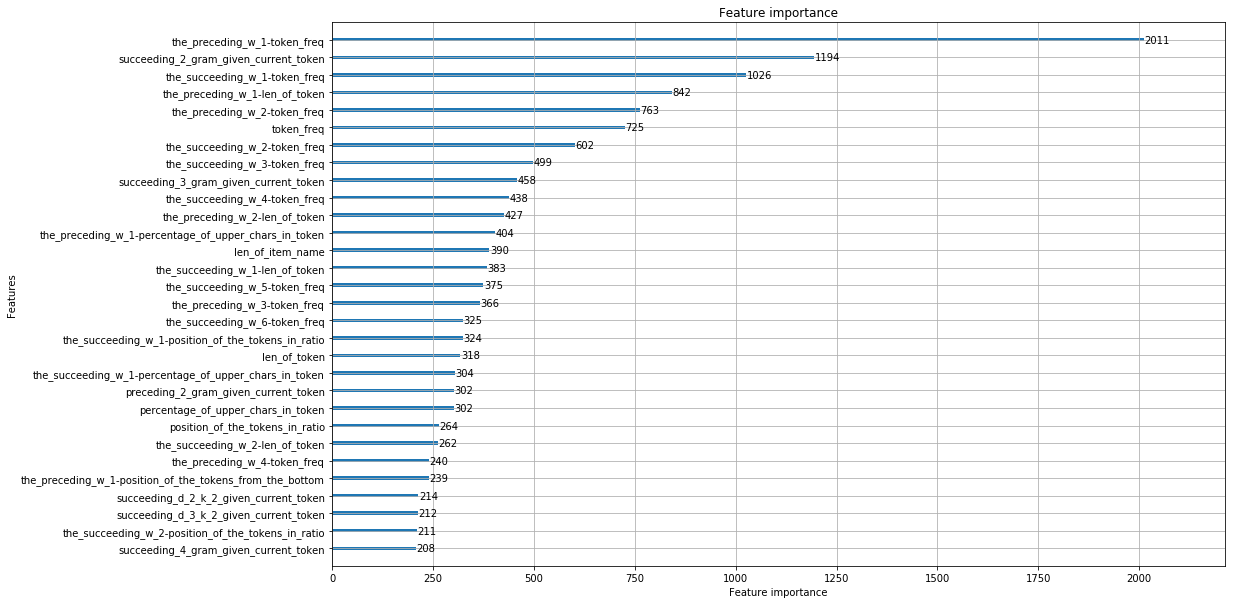

In [23]:
# plot the importance
import matplotlib.pyplot as plt
lgb_model = pickle.load(open('../brand_detector/output/model/2018-09-10/beauty_lgb.model', "rb"))

plt.rcParams['figure.figsize'] = [16, 10]
plot_importance(lgb_model, max_num_features = 30)


# training history

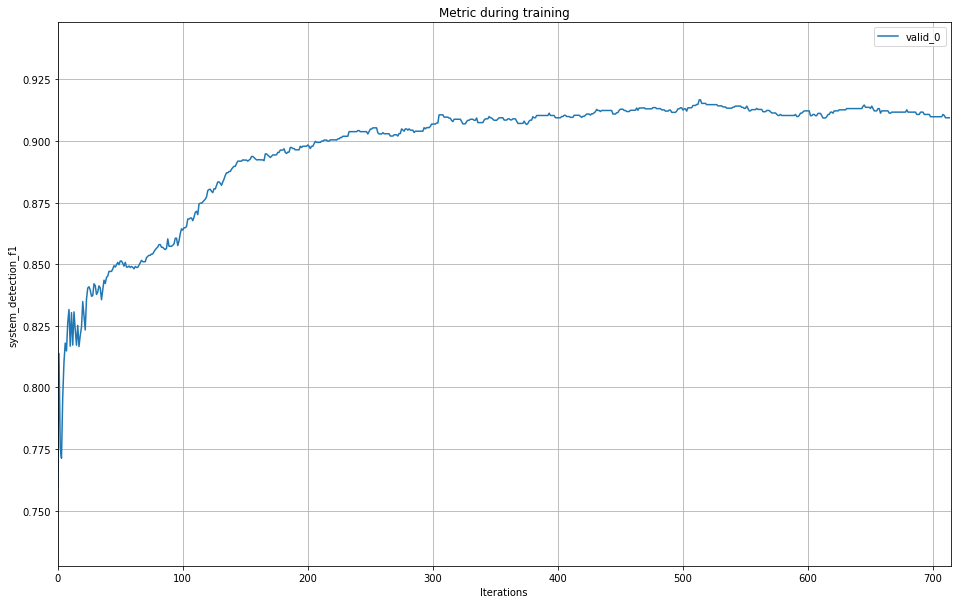

In [24]:
# Plot our custom metric of validating set during training.
lgb.plot_metric(evals_result, metric = 'system_detection_f1')
# make the training result printed 

# testing

In [26]:
def get_positive_token(x, flag = 'atual_brand'):
    '''
    It's a helper function to evaluate our system predictive power.
    
    paras:
    ------------
    x: DataFrame
    flag: str. atual_brand or predicted_brand
    '''
    if flag == 'atual_brand':
        return set(x[x.y_true != 0].tokens.tolist())
    elif flag == 'predicted_brand':
        return set(x[x.y_pred != 0].tokens.tolist())
    else:
        assert ('fuck u, the choise u have is atual_brand or predicted_brand')

def evaluating_system(df):
    '''
    Evaluate our performance of brand detecor using f1, precision, and recall.
        -precision可以反應, 我們系統預測出有brand的的準確度.
        -recall可以反應, 在真實有brand的情況下, 我們能預測出的能力.
    paras:
    -----------------
    df: DataFrame
    '''
    # initialize variables
    acc = 0
    p = 0
    r = 0
    nun_prediction_true = 0
    nun_actual_true = 0
    correct_pred_for_p = 0
    correct_pred_for_r = 0
    #--------------------
    # core
    #--------------------
    for ix, row in df.iterrows():
        if row['acutal_brand'] == row['predicted_brand']:
            acc += 1
        else:
            pass
    for ix, row in df.iterrows():
        if row['predicted_brand'] != set():
            # our system predict there is a brand here
            nun_prediction_true += 1
            if row['acutal_brand'] == row['predicted_brand']:
                correct_pred_for_p += 1
        else:
            pass
    for ix, row in df.iterrows():
        if row['acutal_brand'] != set():
            # there is a actual brand
            nun_actual_true += 1
            if row['acutal_brand'] == row['predicted_brand']:
                correct_pred_for_r += 1
        else:
            pass
    #--------------------
    # output
    #--------------------
    try:        
        accuracy = acc / df.shape[0]  
    except Exception:
        # avoding to divide into zero
        pass
    try:       
        p = correct_pred_for_p / nun_prediction_true
    except Exception:
        # avoding to divide into zero
        pass
    try:          
        r =  correct_pred_for_r / nun_actual_true
    except Exception:
        # avoding to divide into zero
        pass
    try:          
        f1 =  2 * p * r / (p + r)
    except Exception:
        # avoding to divide into zero
        pass   
    return f1, r, p, accuracy

lgb_model = pickle.load(open('../brand_detector/output/model/2018-09-10/beauty_lgb_reducing distribution.model', "rb"))
y_pred = np.argmax(lgb_model.predict(x_test), axis=1)
# combination test and test_predict
df = pd.concat([test[['item_name', 'tokens', 'label']].reset_index(drop = True),
           pd.DataFrame({'y_pred': y_pred})
               ]
         , axis = 1).rename(columns = {'label':'y_true'})
def tokens_index(x):
    x['tokens_index'] = [i+1 for i in range(x.tokens.size)]
    return x


df = df.groupby('item_name').apply(tokens_index)
# check if there Intermidiate part in the groud truth
print (1 in df[df.tokens_index == 2].y_true.value_counts().index)
# check if the model only consider the first token as predictions
print (df[df.tokens_index != 1].y_pred.value_counts() )
df1 = df.groupby('item_name') \
.apply(lambda x: get_positive_token(x, flag = 'atual_brand')) \
.to_frame('acutal_brand').reset_index()
df2 = df.groupby('item_name') \
.apply(lambda x: get_positive_token(x, flag = 'predicted_brand')) \
.to_frame('predicted_brand').reset_index()
# output
evaluation = pd.merge(df1, df2, on = 'item_name', how = 'left')[['item_name', 'acutal_brand','predicted_brand']]
# Conclusion: Model 在TV 先判斷第一個字是不是brand, 如果不是他就認為沒有brand. 
# output
f1, r, p, accuracy = evaluating_system(evaluation)

print ('============testing==============')
print('accuracy: {} - {}'.format(accuracy, name))
print('f1: {} - {}'.format(f1, name))
print('precision: {} - {}'.format(p, name))
print('recall: {} - {}'.format(r, name))
print ('============validating==============')
print('f1_score_sentence_level :{} - {}'.format(np.array(evals_result['valid_0']['system_detection_f1']).max(), name))

True
0    17367
1      512
2      127
Name: y_pred, dtype: int64
============testing==============
accuracy: 0.6414141414141414 - beauty
f1: 0.7214445120714142 - beauty
precision: 0.8242929995363931 - beauty
recall: 0.6414141414141414 - beauty
============validating==============
f1_score_sentence_level :0.9167054443927407 - beauty


In [27]:
'''
Exp:
added sequential feature wo reducing distribution of shopee and amazon| 0.7137318914507242(test), 0.8692380056444027(val)
added sequential feature w reducing distribution of shopee and amazon| 0.7214445120714142 (test), 0.9167054443927407(val)
Conclusion, make source dataset more consistent w target dataset, the result would be better even it means you lose
some source dataset. For example, I filter those len of title is more than shopee to make the distribution matched.

addex tf_idf feature|
Next step:
0.continue to add new features.
1.try Modeling tuning to sovle severe overfitting phenomenon.
2.Null-importance Feature Selection

'''

'\nExp:\nadded sequential feature wo reducing distribution of shopee and amazon| 0.7137318914507242(test), 0.8692380056444027(val)\nadded sequential feature w reducing distribution of shopee and amazon| 0.7214445120714142\n\nNext step:\n0.continue to add new features.\n1.try Modeling tuning to sovle severe overfitting phenomenon.\n2.Null-importance Feature Selection\n\n'